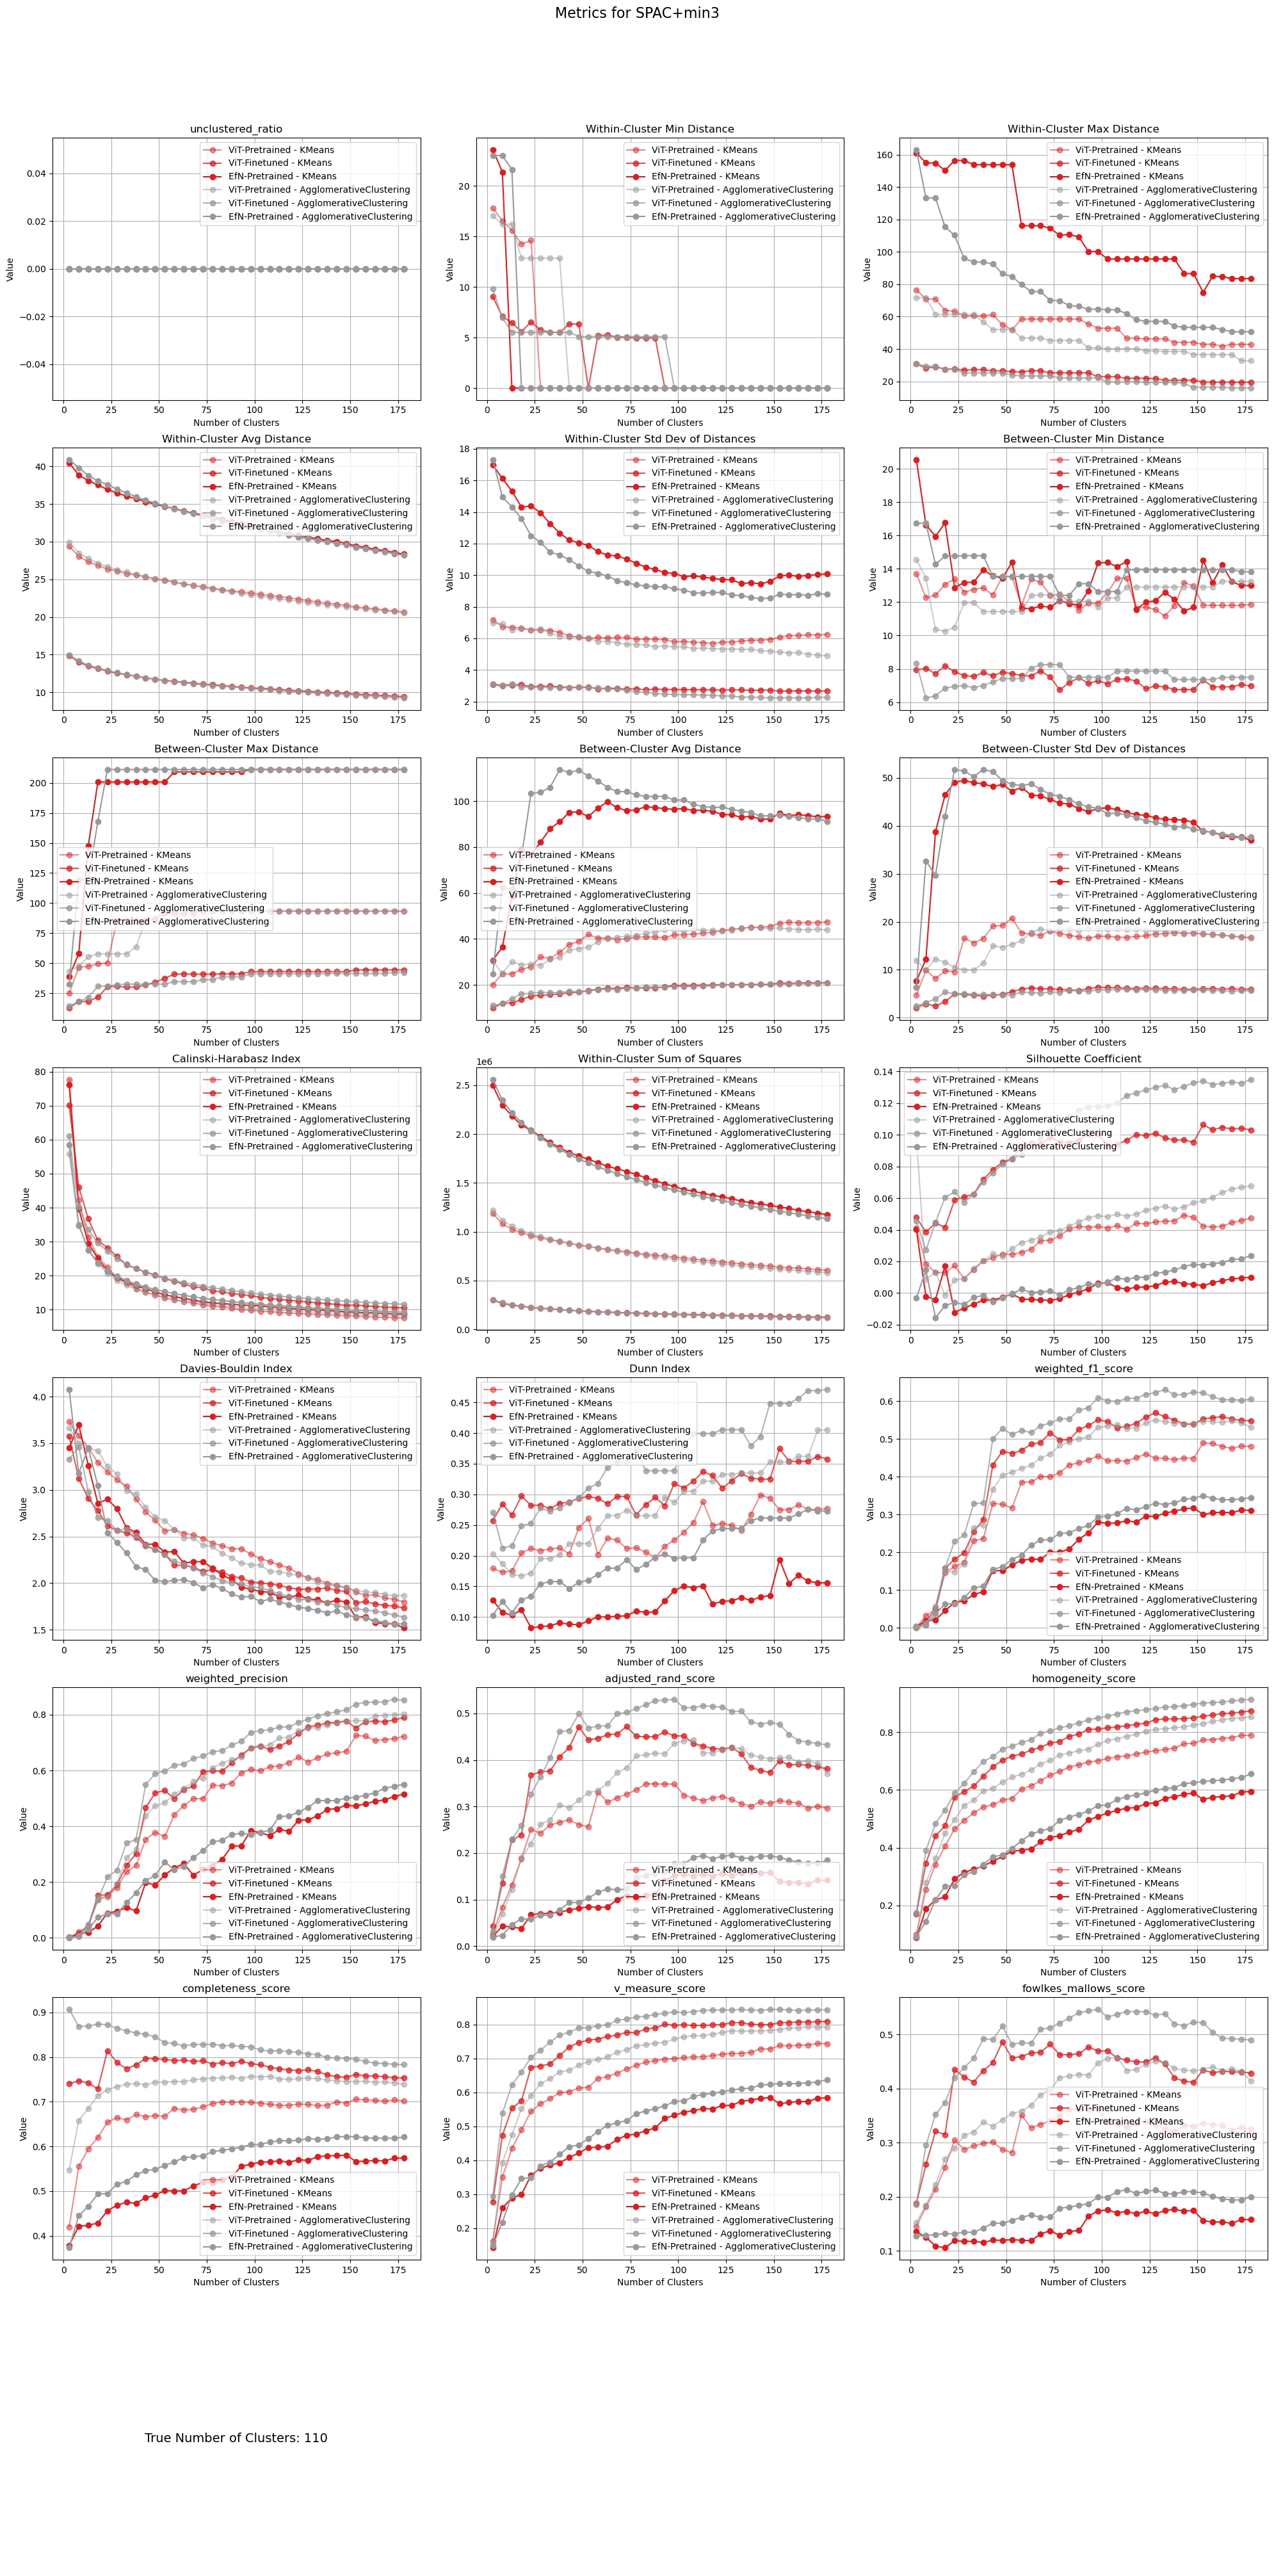

In [2]:
from gorillatracker.classification.clustering import (
    batch_visualize_alg_metrics,
)
from gorillatracker.classification.metrics import formatted_names
import pandas as pd

metrics_df = pd.read_pickle("clustering_results_21sep.pkl")
# visualize_alg_metrics(metrics_df, "SPAC", "ViT-Finetuned", "KMeans", formatted_names)
batch_visualize_alg_metrics(
    metrics_df,
    "SPAC+min3",  # "Bristol",
    ["ViT-Pretrained", "ViT-Finetuned", "EfN-Pretrained"],
    ["KMeans", "AgglomerativeClustering"],
    formatted_names,
)

In [3]:
print(metrics_df.columns)
print(metrics_df.dataset.unique())

Index(['unclustered_ratio', 'global_max_dist', 'global_min_dist',
       'global_avg_dist', 'global_std_dist', 'intra_min_dist',
       'intra_max_dist', 'intra_avg_dist', 'intra_std_dist', 'inter_min_dist',
       'inter_max_dist', 'inter_avg_dist', 'inter_std_dist',
       'calinski_harabasz_index', 'wcss', 'silhouette_coefficient',
       'davies_bouldin_index', 'dunn_index', 'weighted_f1_score',
       'weighted_precision', 'adjusted_rand_score', 'homogeneity_score',
       'completeness_score', 'v_measure_score', 'fowlkes_mallows_score',
       'dataset', 'model', 'algorithm', 'algorithm_params', 'n_clusters',
       'n_true_clusters'],
      dtype='object')
['Synthetic 200c 10n' 'Synthetic 20c 20n' 'SPAC' 'SPAC+min3'
 'SPAC+min3+max10' 'Bristol' 'Bristol+min25+max25']


In [4]:
import pandas as pd


def format_value(value):
    if pd.isna(value) or value == "nan":
        return "nan"
    elif isinstance(value, (int, float)):
        return f"{value:.3f}"
    else:
        return str(value)


def generate_first_graphic_data(df, dataset, model):
    df = df.copy()

    # First, filter the DataFrame
    spac_max3_vit_df = df[(df["dataset"] == dataset) & (df["model"] == model)]

    # List to store the summary of metrics
    metrics_summary = []

    # List of algorithms to check
    algorithms_to_check = spac_max3_vit_df["algorithm"].unique()

    # Iterate over each algorithm
    for algorithm in algorithms_to_check:
        # Filter DataFrame for the current algorithm
        algorithm_df = spac_max3_vit_df[spac_max3_vit_df["algorithm"] == algorithm]

        # Get the rows with max silhouette score, max dunn index, min davies-bouldin index, and max calinski-harabasz index
        max_silhouette_row = algorithm_df.loc[algorithm_df["silhouette_coefficient"].idxmax()]
        max_dunn_row = algorithm_df.loc[algorithm_df["dunn_index"].idxmax()]
        min_davies_bouldin_row = algorithm_df.loc[algorithm_df["davies_bouldin_index"].idxmin()]
        max_calinski_harabasz_row = algorithm_df.loc[algorithm_df["calinski_harabasz_index"].idxmax()]

        # Add rows to the metrics summary
        metrics_summary.extend(
            [
                [
                    "Silhouette Score (max)",
                    algorithm,
                    max_silhouette_row["adjusted_rand_score"],
                    max_silhouette_row["homogeneity_score"],
                    max_silhouette_row["completeness_score"],
                    max_silhouette_row["v_measure_score"],
                    max_silhouette_row["n_clusters"],
                ],
                [
                    "Dunn Index (max)",
                    algorithm,
                    max_dunn_row["adjusted_rand_score"],
                    max_dunn_row["homogeneity_score"],
                    max_dunn_row["completeness_score"],
                    max_dunn_row["v_measure_score"],
                    max_dunn_row["n_clusters"],
                ],
                [
                    "Davies-Bouldin Index (min)",
                    algorithm,
                    min_davies_bouldin_row["adjusted_rand_score"],
                    min_davies_bouldin_row["homogeneity_score"],
                    min_davies_bouldin_row["completeness_score"],
                    min_davies_bouldin_row["v_measure_score"],
                    min_davies_bouldin_row["n_clusters"],
                ],
                [
                    "Calinski-Harabasz Index (max)",
                    algorithm,
                    max_calinski_harabasz_row["adjusted_rand_score"],
                    max_calinski_harabasz_row["homogeneity_score"],
                    max_calinski_harabasz_row["completeness_score"],
                    max_calinski_harabasz_row["v_measure_score"],
                    max_calinski_harabasz_row["n_clusters"],
                ],
            ]
        )

    # Convert to DataFrame for easy display
    return pd.DataFrame(
        metrics_summary,
        columns=[
            "Approach",
            "Algorithm",
            "Rand Score",
            "Homogeneity",
            "Completeness",
            "V-Measure",
            "n_clusters",
        ],
    )


def generate_latex_table(df, dataset, model):
    latex_code = [
        r"\begin{table}[H]",
        r"    \centering",
        r"    \resizebox{\textwidth}{!}{%",
        r"    \begin{tabular}{llccccc}",
        r"    \toprule",
        r"    \multicolumn{2}{l}{Approaches} & \multicolumn{5}{c}{Metrics} \\",
        r"     \cmidrule(lr){3-7}",
        r"    & & ARI & Homogeneity & Completeness & V-Measure & Clusters Found \\",
        r"    \midrule",
    ]

    for approach in df["Approach"].unique():
        latex_code.append(f"    \multicolumn{{7}}{{l}}{{\\textbf{{{approach}}}}} \\\\")
        group = df[df["Approach"] == approach]
        for _, row in group.iterrows():
            formatted_values = [
                format_value(row["Rand Score"]),
                format_value(row["Homogeneity"]),
                format_value(row["Completeness"]),
                format_value(row["V-Measure"]),
                str(row["n_clusters"]),
            ]
            latex_code.append(f"    & {row['Algorithm']} & {' & '.join(formatted_values)} \\\\")
        if approach != df["Approach"].unique()[-1]:
            latex_code.append(r"    \midrule")

    latex_code.extend(
        [
            r"    \bottomrule",
            r"    \end{tabular}%",
            r"    }",
            r"    \caption{Comparison of Clustering Approaches and Algorithms across Various Metrics. Dataset is "
            + dataset
            + " and Model is "
            + model
            + "}",
            r"    \label{tab:clustering-metrics}",
            r"\end{table}",
        ]
    )

    return "\n".join(latex_code)


dataset = "SPAC+min3"
model = "ViT-Finetuned"
metrics_summary_df = generate_first_graphic_data(metrics_df, dataset, model)
print(generate_latex_table(metrics_summary_df, dataset, model))

\begin{table}[H]
    \centering
    \resizebox{\textwidth}{!}{%
    \begin{tabular}{llccccc}
    \toprule
    \multicolumn{2}{l}{Approaches} & \multicolumn{5}{c}{Metrics} \\
     \cmidrule(lr){3-7}
    & & ARI & Homogeneity & Completeness & V-Measure & Clusters Found \\
    \midrule
    \multicolumn{7}{l}{\textbf{Silhouette Score (max)}} \\
    & KMeans & 0.398 & 0.855 & 0.761 & 0.805 & 153 \\
    & AgglomerativeClustering & 0.433 & 0.914 & 0.783 & 0.843 & 178 \\
    & HDBSCAN & 0.048 & 0.571 & 0.764 & 0.653 & 101 \\
    \midrule
    \multicolumn{7}{l}{\textbf{Dunn Index (max)}} \\
    & KMeans & 0.398 & 0.855 & 0.761 & 0.805 & 153 \\
    & AgglomerativeClustering & 0.433 & 0.914 & 0.783 & 0.843 & 178 \\
    & HDBSCAN & 0.048 & 0.571 & 0.764 & 0.653 & 101 \\
    \midrule
    \multicolumn{7}{l}{\textbf{Davies-Bouldin Index (min)}} \\
    & KMeans & 0.381 & 0.874 & 0.753 & 0.809 & 178 \\
    & AgglomerativeClustering & 0.433 & 0.914 & 0.783 & 0.843 & 178 \\
    & HDBSCAN & 0.048 & 0.571 

# Algorithms

In [5]:
import pandas as pd
import numpy as np

def extract_data_best_algorithms_can_do(df):
    # Group by Dataset, Algorithm, and Model
    grouped = df.groupby(['dataset', 'algorithm', 'model'])
    
    report_data = []
    
    for (dataset, algorithm, model), group in grouped:
        # Find the row with the top ARI (adjusted_rand_score)
        top_ari_row = group.loc[group['adjusted_rand_score'].idxmax()]
        
        # Get the true number of clusters (assuming it's constant for each dataset-algorithm-model combination)
        true_clusters = group['n_true_clusters'].iloc[0]
        
        # Find the row with n_clusters closest to true_clusters
        closest_clusters_row = group.loc[(group['n_clusters'] - true_clusters).abs().idxmin()]
        
        report_data.append({
            'Dataset': dataset,
            'Algorithm': algorithm,
            'Model': model,
            'True Clusters': true_clusters,
            'ARI': top_ari_row['adjusted_rand_score'],
            'Clusters': top_ari_row['n_clusters'],
            'True ARI': closest_clusters_row['adjusted_rand_score']
        })
    
    return pd.DataFrame(report_data)

def format_value(value):
    if abs(value) < 1e-10:  # Consider values very close to zero as zero
        return "0"
    return f"{value:.3f}".rstrip('0').rstrip('.').replace('-0', '0')

def latex_table_best_algorithms_can_do(df):
    latex_code = [
        r"\begin{table}[H]",
        r"    \centering",
        r"    \resizebox{\textwidth}{!}{%",
        r"    \begin{tabular}{l|c|ccc|ccc|ccc}",
        r"    \toprule",
        r"    & True & \multicolumn{3}{c|}{KMeans} & \multicolumn{3}{c|}{AgglomerativeClustering} & \multicolumn{3}{c}{HDBSCAN} \\",
        r"    Embedding Space & Clusters & True ARI & ARI & Clusters & True ARI & ARI & Clusters & True ARI & ARI & Clusters \\",
        r"    \midrule",
    ]

    datasets = df['Dataset'].unique()
    for i, dataset in enumerate(datasets):
        group = df[df['Dataset'] == dataset]
        latex_code.append(f"    \\multicolumn{{11}}{{l}}{{\\textbf{{{dataset}}}}} \\\\")

        # Pivot the data
        pivot = group.pivot(index='Model', columns='Algorithm', 
                            values=['True Clusters', 'ARI', 'Clusters', 'True ARI'])
        
        for model in pivot.index:
            row = pivot.loc[model]
            true_clusters = row['True Clusters'].iloc[0]  # All algorithms have same True Clusters
            values = [
                model,
                str(int(true_clusters)),
            ]
            for alg in ['KMeans', 'AgglomerativeClustering', 'HDBSCAN']:
                values.extend([
                    format_value(row['True ARI'][alg]),
                    format_value(row['ARI'][alg]),
                    str(int(row['Clusters'][alg]))
                ])
            latex_code.append("    " + " & ".join(values) + r" \\")
        
        # Add a midrule between datasets, except after the last dataset
        if i < len(datasets) - 1:
            latex_code.append(r"    \midrule")

    latex_code.extend([
        r"    \bottomrule",
        r"    \end{tabular}%",
        r"    }",
        r"    \caption{Clustering Performance Metrics for Different Models and Algorithms}",
        r"    \label{tab:clustering-algorithms}",
        r"\end{table}",
    ])

    return "\n".join(latex_code)

# Example usage:
# Assuming metrics_df is your input DataFrame
report_df = extract_data_best_algorithms_can_do(metrics_df)
print(latex_table_best_algorithms_can_do(report_df))

\begin{table}[H]
    \centering
    \resizebox{\textwidth}{!}{%
    \begin{tabular}{l|c|ccc|ccc|ccc}
    \toprule
    & True & \multicolumn{3}{c|}{KMeans} & \multicolumn{3}{c|}{AgglomerativeClustering} & \multicolumn{3}{c}{HDBSCAN} \\
    Embedding Space & Clusters & True ARI & ARI & Clusters & True ARI & ARI & Clusters & True ARI & ARI & Clusters \\
    \midrule
    \multicolumn{11}{l}{\textbf{Bristol}} \\
    EfN-Finetuned & 7 & 0.083 & 0.111 & 18 & 0.17 & 0.172 & 5 & 0.009 & 0.059 & 2 \\
    EfN-Pretrained & 7 & 0.083 & 0.111 & 18 & 0.17 & 0.172 & 5 & 0.009 & 0.059 & 2 \\
    ViT-Finetuned & 7 & 0.166 & 0.191 & 6 & 0.142 & 0.213 & 11 & 0.094 & 0.094 & 10 \\
    ViT-Pretrained & 7 & 0.151 & 0.223 & 22 & 0.206 & 0.209 & 13 & 0.077 & 0.077 & 2 \\
    \midrule
    \multicolumn{11}{l}{\textbf{Bristol+min25+max25}} \\
    EfN-Finetuned & 7 & 0.049 & 0.157 & 16 & 0.09 & 0.164 & 9 & 0.081 & 0.081 & 2 \\
    EfN-Pretrained & 7 & 0.049 & 0.157 & 16 & 0.09 & 0.164 & 9 & 0.081 & 0.081 & 2 \\
  

Processing configurations:   0%|          | 0/1 [00:00<?, ?it/s]

Processing SPAC+min3 ViT-Finetuned KMeans
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 3}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 8}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 13}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 18}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 23}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 28}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 33}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 38}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 43}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 48}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 53}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 58}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 63}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 68}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 73}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 78}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 83}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 88}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 93}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 98}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 103}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 108}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 113}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 118}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 123}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 128}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 133}
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 138}
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 143}
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 148}
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 153}
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 158}
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 163}
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 168}


Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 173}
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 178}
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 183}
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 188}
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 193}
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 198}
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 203}
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 208}
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 213}
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 218}
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 223}
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 228}
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 233}
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 238}
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 243}
Processing SPAC+min3 ViT-Finetuned KMeans {'n_clusters': 248}
Processi

Processing configurations: 100%|██████████| 1/1 [04:31<00:00, 271.86s/it]


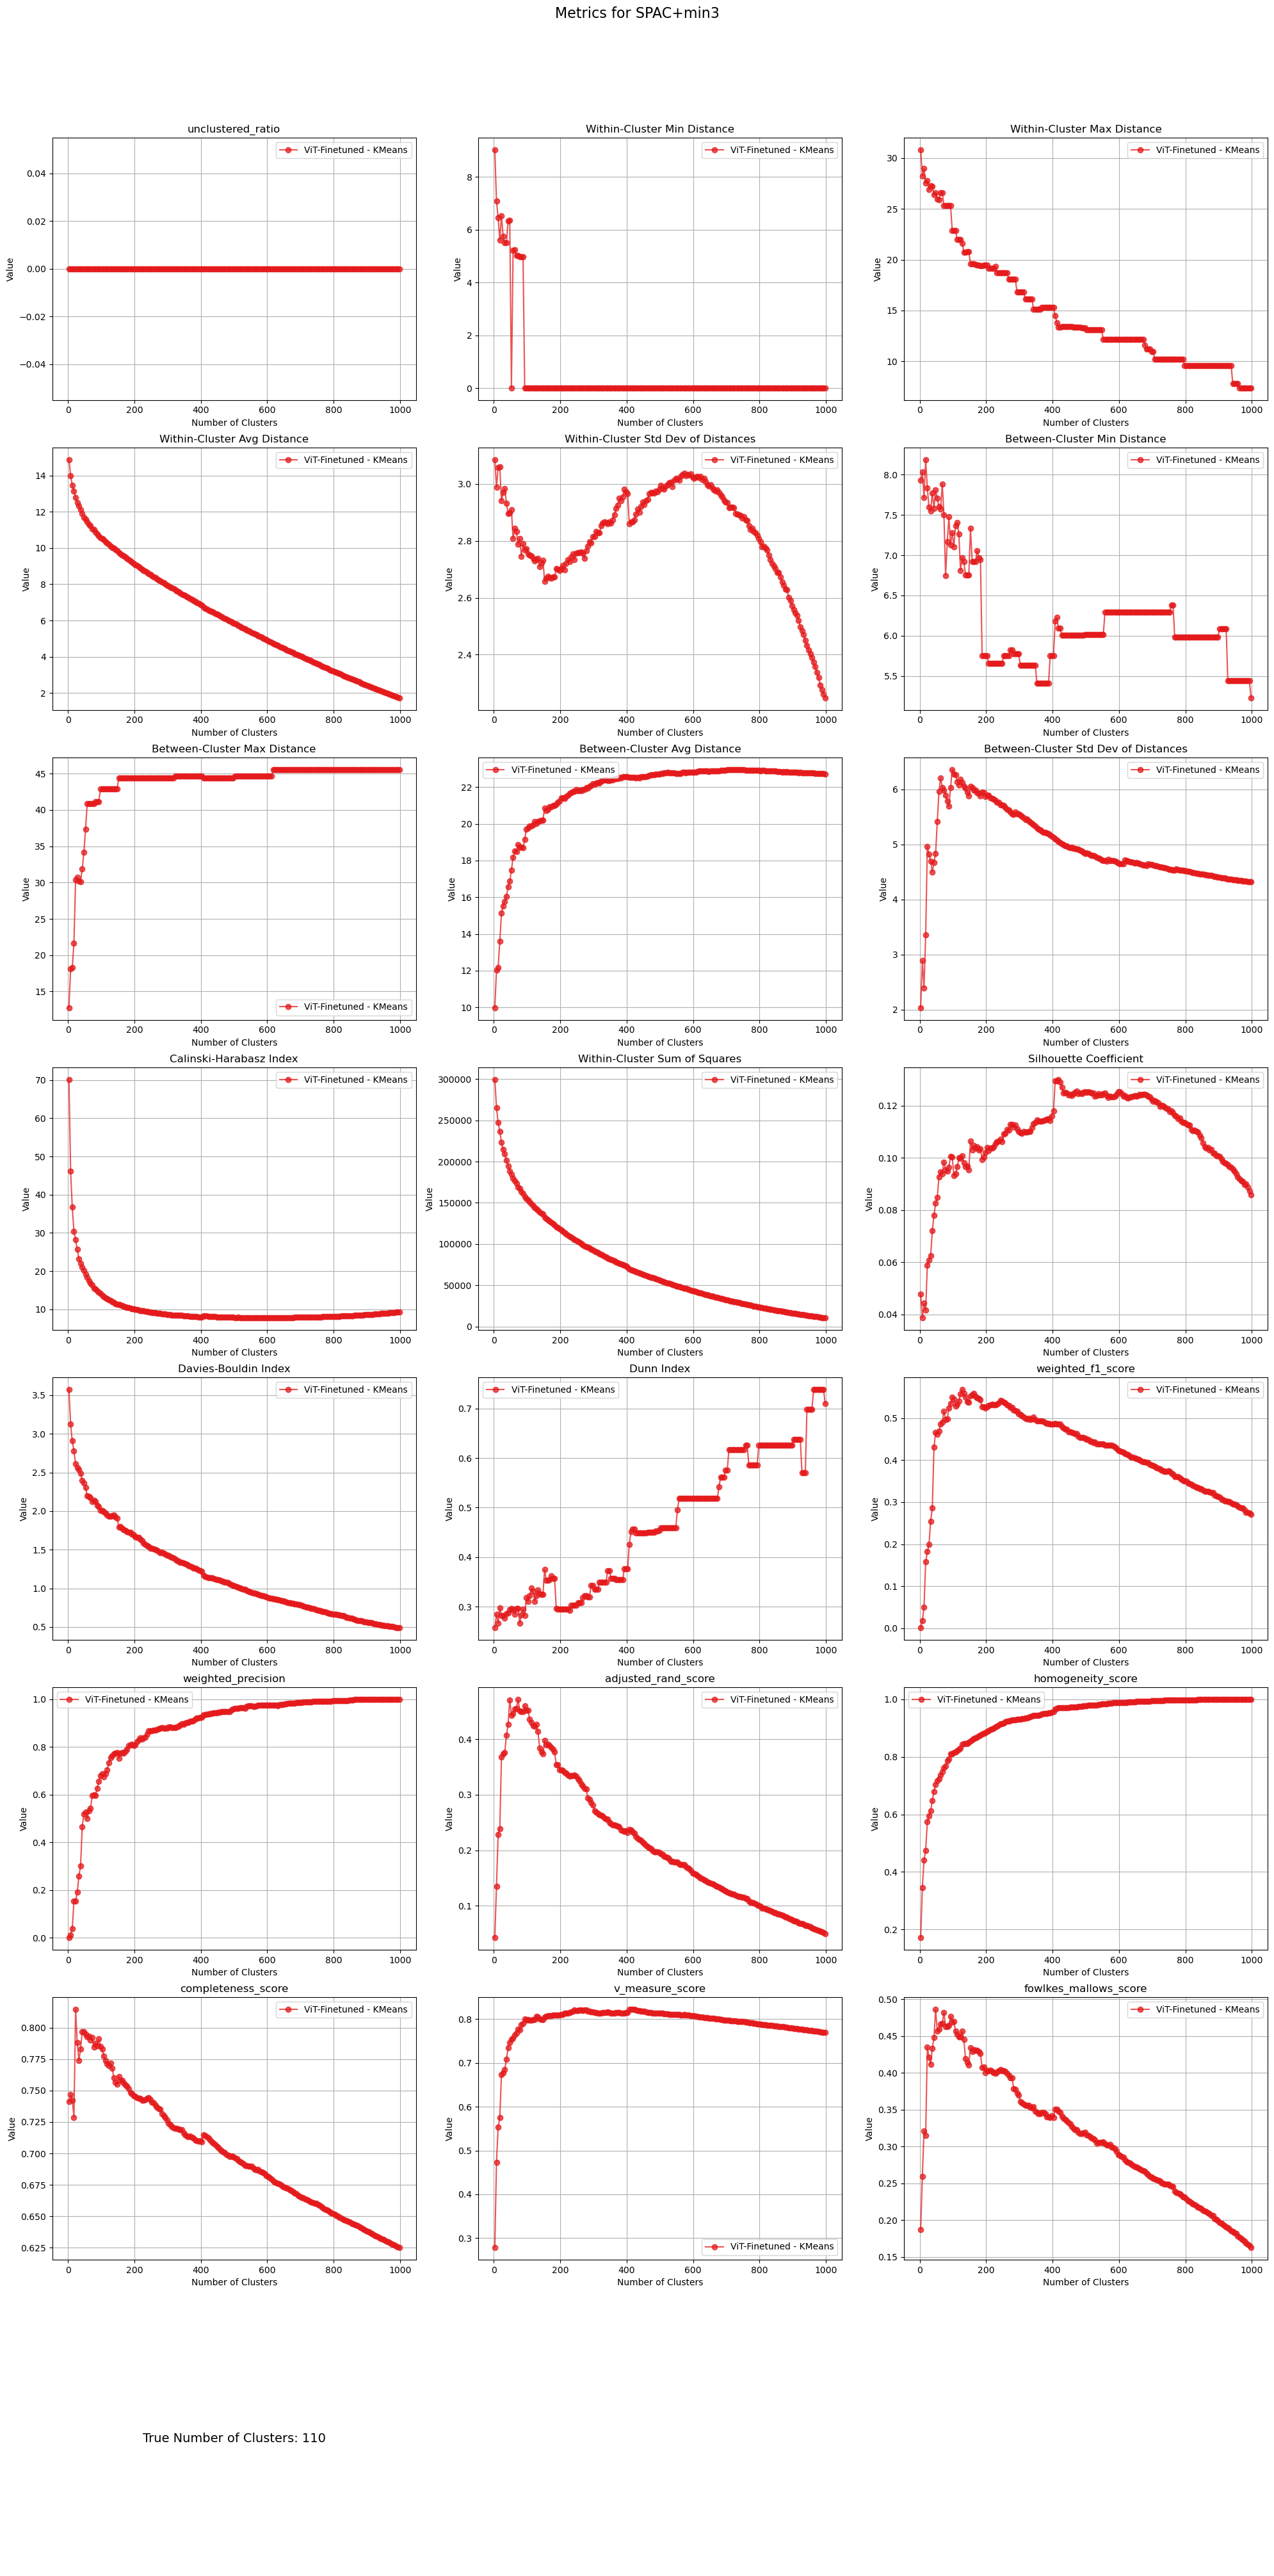

In [6]:
# NOTE(liamvdv): We're investiagting the performance of silouhette score -- maybe we didn't push the clustering far enough.
from gorillatracker.classification.clustering import (
    sweep_clustering_algorithms,
    configs,
    speed_level,
    visualize_alg_metrics,
    calculate_metrics,
    batch_visualize_alg_metrics,
    EXT_MERGED_DF,
    MERGED_DF,
    param_grid,
    speed,
)
from gorillatracker.classification.metrics import formatted_names
import pandas as pd

results2_df = sweep_clustering_algorithms(
    EXT_MERGED_DF,
    [("SPAC+min3", "ViT-Finetuned", "KMeans", param_grid({"n_clusters": range(3, 1000, speed(1, 5, 20))}))],
    cache_dir="./cache_cluster_sweep",
)
# visualize_alg_metrics(metrics_df, "SPAC", "ViT-Finetuned", "KMeans", formatted_names)
batch_visualize_alg_metrics(
    results2_df,
    "SPAC+min3",
    ["ViT-Pretrained", "ViT-Finetuned", "EfN-Pretrained"],
    ["KMeans", "AgglomerativeClustering"],
    formatted_names,
)